<a href="https://colab.research.google.com/github/sinaziaee/paper_field_prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading modules and libraries

In [1]:
import torch
from torch.nn import Parameter, ModuleDict, ModuleList, Linear, ParameterDict
print("PyTorch has version {}".format(torch.__version__))
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html &> /dev/null
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html &> /dev/null
!pip install -q torch-geometric &> /dev/null
!pip install ogb &> /dev/null
!pip install matplotlib==3.1.3 &> /dev/null
!pip install pytorch-memlab &> /dev/null

##
import torch_geometric
print(torch_geometric.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Dataset loader
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
dataset = PygNodePropPredDataset(name='ogbn-mag')
from torch_geometric.profile.profile import profileit
from torch_sparse import SparseTensor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import copy
from tqdm import tqdm
from copy import copy

PyTorch has version 1.12.1+cu113
2.1.0


Downloaded 0.40 GB: 100%|██████████| 413/413 [00:08<00:00, 48.93it/s]


Extracting dataset/mag.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1639.68it/s]

Saving...



Done!


In [2]:
# imporiting libraries
import torch.nn.functional as F

from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, RGCNConv
from sklearn.metrics import f1_score

from torch_geometric.utils import to_undirected
from torch_geometric.data import Data, GraphSAINTRandomWalkSampler
from torch_geometric.utils.hetero import group_hetero_graph
from torch_geometric.nn import MessagePassing

In [3]:
# hyper parameters
log_steps = 1
num_layers = 2
hidden_channels = 256
dropout = 0.5
lr = 0.01
batch_size = 2000
num_steps = 30
walk_length = 2
epochs = 101
runs = 1
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [4]:
!pip install GPUtil &> /dev/null

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

# Preparing the dataset

In [5]:
data = dataset[0]
no_paper = data.num_nodes_dict['paper']
no_study_fields = data.num_nodes_dict['field_of_study']
m_key = 'paper', 'has_topic', 'field_of_study'
no_paper_study_fields = data.edge_index_dict[m_key].shape[1]
print('no paper:', no_paper)
print('no study fields:', no_study_fields)
print('no paper study fields:', no_paper_study_fields)

no paper: 736389
no study fields: 59965
no paper study fields: 7505078


In [6]:
# selecting edges connected to field of studies
study_fields = data.edge_index_dict[m_key][1].numpy()
print(study_fields)
study_fields = list(study_fields)
study_fields_list = [0 for i in range(no_study_fields)]
for each in study_fields:
  study_fields_list[each] += 1
# number of papers with each field of studies
study_fields_list = np.array(study_fields_list)
print('number of papers for each study field: ', study_fields_list)
# creating a dictionary of papers and their corresponding fields of studies
papers_dict = dict(zip([i for i in range(no_paper)], [[] for i in range(no_paper)]))
for each in data.edge_index_dict[m_key].T.numpy():
  paper = each[0]
  field = each[1]
  papers_dict[paper].append(field)

print(study_fields_list[study_fields_list==1].shape[0])
print(study_fields_list[study_fields_list>50000])
print('field of study with the maximum number of papers: ', study_fields_list.argmax())
field_of_study_with_max_papers = study_fields_list.argmax()

[  145  2215  3205 ... 21458 22283 31934]
number of papers for each study field:  [   7 1353  609 ...    2    1    1]
16758
[ 87464 129205  96621  86355  70668  67323 189963 736389  71231]
field of study with the maximum number of papers:  14055


16758 fields of study are used only in one paper. Field of study "14055" is used in all papers. 3 papers only have 14055 as their only field of study.
We will select the fields of study that are used in most number of papers. we will filter them based on fields that are used higher than 10000, 20000, ..., 50000 papers.

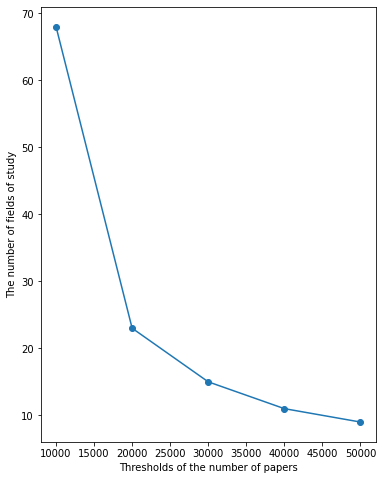


number of papers:     [0, 10000, 20000, 30000, 40000, 50000]
number of study fields: [59965, 68, 23, 15, 11, 9]


In [7]:
# selecting threshold list for visualization of the number of papers in each field of study
threshold_list = [i * 10000 for i in range(6)]
# threshold_list = [0, 1, 100, 5000]
result_list = []
# finding the number of papers on each threshold
for each in threshold_list:
  result_list.append(study_fields_list[study_fields_list>each].shape[0])
# visualization
plt.figure(figsize=(6, 8))
plt.scatter(threshold_list[1:], result_list[1:])
plt.plot(threshold_list[1:], result_list[1:])
plt.xlabel('Thresholds of the number of papers')
plt.ylabel('The number of fields of study')
# for i in range(len(result_list)):
#     plt.annotate(result_list[i], (threshold_list[i], result_list[i] + 0.2))
plt.show()
print(f'\nnumber of papers:     {threshold_list}')
print(f'number of study fields: {result_list}')

In [8]:
keys = [i for i in range(no_study_fields)] # study fields
values = list(study_fields_list) # number of papers
study_fields_dict = dict(zip(keys, values))
sorted_dict = dict(sorted(study_fields_dict.items(), key=lambda item: item[1]))

def find_field_with_max_no_papers(temp_dict, study_fields_list_in_each_paper):
  temp_list = []
  # removing the most used field of study (14055)
  if len(study_fields_list_in_each_paper) == 1: # if the list only has 14055 as study field then return it, otherwise find the next max field
    # print(study_fields_list_in_each_paper)
    return field_of_study_with_max_papers
  study_fields_list_in_each_paper.remove(field_of_study_with_max_papers)
  # find the order (higher number -> higer priority)
  for field in study_fields_list_in_each_paper:
    temp_list.append(temp_dict[field])
  # finding the study field with maximum number of papers
  maximum = max(temp_list)
  # finding it's index
  max_index = temp_list.index(maximum)
  # returning the field of study itself (not the index)
  study_field_with_max_no_papers = study_fields_list_in_each_paper[max_index]
  return study_field_with_max_no_papers

papers_study_fields = [field_of_study_with_max_papers for i in range(no_paper)]
temp_dict = dict(zip(list(sorted_dict.keys()), [i for i in range(len(list(sorted_dict.keys())))]))
# find the most used field of study
for i in range(no_paper):
  study_fields_list_in_each_paper = papers_dict[i][:]
  study_field_with_max_no_papers = find_field_with_max_no_papers(temp_dict, study_fields_list_in_each_paper) 
  papers_study_fields[i] = study_field_with_max_no_papers
# saving the result as it may take a while
papers_study_fields = np.array(papers_study_fields)
np.savetxt('saved_list.txt', papers_study_fields, fmt='%d')
b = np.loadtxt('saved_list.txt', dtype=int)

In [9]:
temp_set = list()
for each in list(papers_study_fields):
  if each not in temp_set:
    temp_set.append(each)

my_dict = dict(zip(list(temp_set), [0 for i in range(len(temp_set))]))
for each in list(papers_study_fields):
  my_dict[each]+=1

new_y_dict = dict()
reverse_new_y_dict = dict()

for i, each in enumerate(temp_set):
  new_y_dict[each] = i
  reverse_new_y_dict[i] = each

new_y = []
for each in list(papers_study_fields):
  new_y.append(new_y_dict[each])
new_y = np.array(new_y)

new_y = torch.from_numpy(new_y.reshape((new_y.shape[0], 1)))

num_classes = len(temp_set)

# Pipeline

## model architecture

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(GCN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(
            GCNConv(in_channels, hidden_channels, normalize=False))
        for _ in range(num_layers - 2):
            self.convs.append(
                GCNConv(hidden_channels, hidden_channels, normalize=False))
        self.convs.append(
            GCNConv(hidden_channels, out_channels, normalize=False))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

In [11]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x.log_softmax(dim=-1)

In [12]:
@profileit()
def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx]
    
    loss = F.nll_loss(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return loss.item()
  
@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval()

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']['paper']],
        'y_pred': y_pred[split_idx['train']['paper']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']['paper']],
        'y_pred': y_pred[split_idx['valid']['paper']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']['paper']],
        'y_pred': y_pred[split_idx['test']['paper']],
    })['acc']

    # print(data.y[split_idx['test']['paper']])
    # print(y_pred[split_idx['test']['paper']])

    score = f1_score(data.y[split_idx['test']['paper']].cpu(), 
                     y_pred[split_idx['test']['paper']].cpu(), 
                     average='micro')

    return train_acc, valid_acc, test_acc, score

## Sage graph model result

In [ ]:
print('mem =', 'aloc:', torch.cuda.memory_allocated(0)/1024/1024/1024, 'all:', torch.cuda.memory_reserved(0)/1024/1024/1024)

mem = aloc: 0.6812448501586914 all: 13.234375


In [ ]:
rel_data = dataset[0]

# We are only interested in paper <-> paper relations.
data = Data(
    x=rel_data.x_dict['paper'],
    edge_index=rel_data.edge_index_dict[('paper', 'cites', 'paper')],
    y=rel_data.y_dict['paper'])
    # y=new_y)

print(data)

data = T.ToSparseTensor()(data)
data.adj_t = data.adj_t.to_symmetric()

split_idx = dataset.get_idx_split()
train_idx = split_idx['train']['paper'].to(device)

which_model = 0

# Sage model
if which_model == 0:
    model = SAGE(data.num_features, hidden_channels,
                  num_classes, num_layers,
                  dropout).to(device)
# GCN model
else:
    model = GCN(data.num_features, hidden_channels,
                num_classes, num_layers,
                dropout).to(device)

    # Pre-compute GCN normalization.
    adj_t = data.adj_t.set_diag()
    deg = adj_t.sum(dim=1).to(torch.float)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    adj_t = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
    data.adj_t = adj_t

Data(x=[736389, 128], edge_index=[2, 5416271], y=[736389, 1])


In [ ]:
data = data.to(device)

evaluator = Evaluator(name='ogbn-mag')
loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

for run in range(runs):
  print("Run:", run, '#'*100)
  model.reset_parameters()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  start = time.time()
  for epoch in range(0, epochs):
    loss, stats = train(model, data, train_idx, optimizer)
    result = test(model, data, split_idx, evaluator)
    loss_list.append(loss)
    train_acc, valid_acc, test_acc, test_f1 = result
    train_acc_list.append(train_acc)
    val_acc_list.append(valid_acc)
    test_acc_list.append(test_acc)
    if epoch % 20 == 0:
      print(f'Run: {run + 1:02d}, '
                  f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_acc:.2f}%, '
                  f'Valid: {100 * valid_acc:.2f}% '
                  f'Test: {100 * test_acc:.2f}% '
                  f'F1-Score: {100 * test_f1:.2f}%')
      print(stats)
  stop = time.time()
  print(f"Training time: {stop - start}s")


Run: 0 ####################################################################################################
Run: 01, Epoch: 00, Loss: 6.6601, Train: 30.27%, Valid: 27.39% Test: 26.49% F1-Score: 26.49%
Stats(time=1.208510009765625, max_allocated_cuda=7894.13, max_reserved_cuda=8334.0, max_active_cuda=7894.13, nvidia_smi_free_cuda=1536.05, nvidia_smi_used_cuda=14305.73)
Run: 01, Epoch: 20, Loss: 1.4965, Train: 62.85%, Valid: 58.41% Test: 58.86% F1-Score: 58.86%
Stats(time=1.09498876953125, max_allocated_cuda=7897.8, max_reserved_cuda=8334.0, max_active_cuda=7897.8, nvidia_smi_free_cuda=1536.05, nvidia_smi_used_cuda=14305.73)
Run: 01, Epoch: 40, Loss: 1.2201, Train: 67.41%, Valid: 61.88% Test: 61.82% F1-Score: 61.82%
Stats(time=1.0693292236328125, max_allocated_cuda=7897.8, max_reserved_cuda=8334.0, max_active_cuda=7897.8, nvidia_smi_free_cuda=1536.05, nvidia_smi_used_cuda=14305.73)
Run: 01, Epoch: 60, Loss: 1.1441, Train: 68.44%, Valid: 62.68% Test: 62.58% F1-Score: 62.58%
Stats(time=1.0

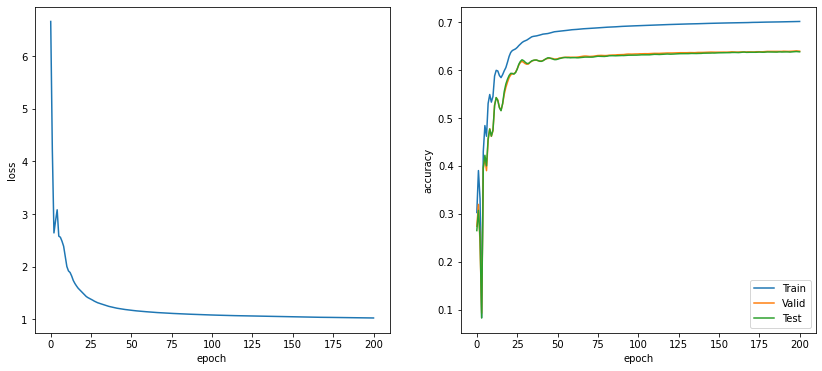

In [ ]:
#
plt.figure(figsize=(14, 6))
#
plt.subplot(121)
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
#
plt.subplot(122)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Valid')
plt.plot(test_acc_list, label='Test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#
plt.legend()
plt.show()

## GCN model result

In [ ]:
print('mem =', 'aloc:', torch.cuda.memory_allocated(0)/1024/1024/1024, 'all:', torch.cuda.memory_reserved(0)/1024/1024/1024)

mem = aloc: 0.6798944473266602 all: 12.53125


In [ ]:
rel_data = dataset[0]

data = Data(
    x=rel_data.x_dict['paper'],
    edge_index=rel_data.edge_index_dict[('paper', 'cites', 'paper')],
    # y=rel_data.y_dict['paper'])
    y=new_y)

print(data)

num_classes = len(temp_set)

data = T.ToSparseTensor()(data)
data.adj_t = data.adj_t.to_symmetric()

split_idx = dataset.get_idx_split()
train_idx = split_idx['train']['paper'].to(device)

which_model = 1

# Sage model
if which_model == 0:
    model = SAGE(data.num_features, hidden_channels,
                  num_classes, num_layers,
                  dropout).to(device)
# GCN model
else:
    model = GCN(data.num_features, 128,
                num_classes, num_layers,
                dropout).to(device)

    # Pre-compute GCN normalization.
    adj_t = data.adj_t.set_diag()
    deg = adj_t.sum(dim=1).to(torch.float)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    adj_t = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
    data.adj_t = adj_t

Data(x=[736389, 128], edge_index=[2, 5416271], y=[736389, 1])


In [ ]:
data = data.to(device)

evaluator = Evaluator(name='ogbn-mag')
loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

for run in range(runs):
  print("Run:", run, '#'*100)
  model.reset_parameters()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  start = time.time()
  for epoch in range(0, epochs):
    loss, stats = train(model, data, train_idx, optimizer)
    result = test(model, data, split_idx, evaluator)
    train_acc, valid_acc, test_acc, test_f1 = result
    loss_list.append(loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(valid_acc)
    test_acc_list.append(test_acc)
    if epoch % 20 == 0:
      print(f'Run: {run + 1:02d}, '
                  f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_acc:.2f}%, '
                  f'Valid: {100 * valid_acc:.2f}% '
                  f'Test: {100 * test_acc:.2f}% '
                  f'F1-Score: {100 * test_f1:.2f}%')
      print(stats)
  stop = time.time()
  print(f"Training time: {stop - start}s")

Run: 0 ####################################################################################################
Run: 01, Epoch: 00, Loss: 6.7018, Train: 38.84%, Valid: 30.38% Test: 32.27% F1-Score: 32.27%
Stats(time=1.3770419921875, max_allocated_cuda=8700.64, max_reserved_cuda=9074.0, max_active_cuda=8700.64, nvidia_smi_free_cuda=948.89, nvidia_smi_used_cuda=14892.89)
Run: 01, Epoch: 20, Loss: 2.2167, Train: 52.43%, Valid: 45.02% Test: 45.29% F1-Score: 45.29%
Stats(time=1.3010291748046876, max_allocated_cuda=8702.03, max_reserved_cuda=8992.0, max_active_cuda=8702.03, nvidia_smi_free_cuda=760.16, nvidia_smi_used_cuda=15081.62)
Run: 01, Epoch: 40, Loss: 1.5989, Train: 62.86%, Valid: 57.92% Test: 58.16% F1-Score: 58.16%
Stats(time=1.26175390625, max_allocated_cuda=8702.03, max_reserved_cuda=8992.0, max_active_cuda=8702.03, nvidia_smi_free_cuda=760.16, nvidia_smi_used_cuda=15081.62)
Run: 01, Epoch: 60, Loss: 1.3811, Train: 66.38%, Valid: 61.06% Test: 61.06% F1-Score: 61.06%
Stats(time=1.31598

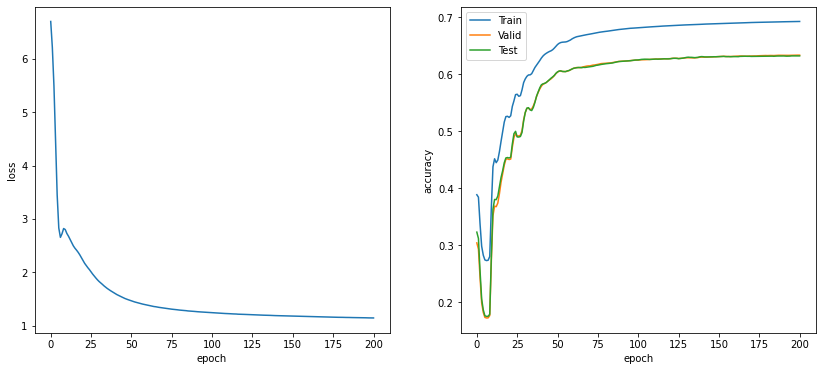

In [ ]:
#
plt.figure(figsize=(14, 6))
#
plt.subplot(121)
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
#
plt.subplot(122)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Valid')
plt.plot(test_acc_list, label='Test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#
plt.legend()
plt.show()

## RGCN model result

In [ ]:
print('mem =', 'aloc:', torch.cuda.memory_allocated(0)/1024/1024/1024, 'all:', torch.cuda.memory_reserved(0)/1024/1024/1024, 'max_res:', torch.cuda.max_memory_reserved(0)/1024/1024/1024)

mem = aloc: 0.0 all: 0.0 max_res: 0.0


In [ ]:
class RGCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, node_types, edge_types):
        super(RGCNConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        # `ModuleDict` does not allow tuples :(
        self.rel_lins = ModuleDict({
            f'{key[0]}_{key[1]}_{key[2]}': Linear(in_channels, out_channels,
                                                  bias=False)
            for key in edge_types
        })

        self.root_lins = ModuleDict({
            key: Linear(in_channels, out_channels, bias=True)
            for key in node_types
        })

        self.reset_parameters()

    def reset_parameters(self):
        for lin in self.rel_lins.values():
            lin.reset_parameters()
        for lin in self.root_lins.values():
            lin.reset_parameters()

    def forward(self, x_dict, adj_t_dict):
        out_dict = {}
        for key, x in x_dict.items():
            out_dict[key] = self.root_lins[key](x)

        for key, adj_t in adj_t_dict.items():
            key_str = f'{key[0]}_{key[1]}_{key[2]}'
            x = x_dict[key[0]]
            out = self.rel_lins[key_str](adj_t.matmul(x, reduce='mean'))
            out_dict[key[2]].add_(out)

        return out_dict


class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, num_nodes_dict, x_types, edge_types):
        super(RGCN, self).__init__()

        node_types = list(num_nodes_dict.keys())

        self.embs = ParameterDict({
            key: Parameter(torch.Tensor(num_nodes_dict[key], in_channels))
            for key in set(node_types).difference(set(x_types))
        })

        self.convs = ModuleList()
        self.convs.append(
            RGCNConv(in_channels, hidden_channels, node_types, edge_types))
        for _ in range(num_layers - 2):
            self.convs.append(
                RGCNConv(hidden_channels, hidden_channels, node_types,
                         edge_types))
        self.convs.append(
            RGCNConv(hidden_channels, out_channels, node_types, edge_types))

        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        for emb in self.embs.values():
            torch.nn.init.xavier_uniform_(emb)
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x_dict, adj_t_dict):
        x_dict = copy.copy(x_dict)
        for key, emb in self.embs.items():
            x_dict[key] = emb

        for conv in self.convs[:-1]:
            x_dict = conv(x_dict, adj_t_dict)
            for key, x in x_dict.items():
                x_dict[key] = F.relu(x)
                x_dict[key] = F.dropout(x, p=self.dropout,
                                        training=self.training)
        return self.convs[-1](x_dict, adj_t_dict)

In [ ]:
@profileit()
def train(model, x_dict, adj_t_dict, y_true, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(x_dict, adj_t_dict)['paper'].log_softmax(dim=-1)
    loss = F.nll_loss(out[train_idx], y_true[train_idx].squeeze())
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(model, x_dict, adj_t_dict, y_true, split_idx, evaluator):
    model.eval()

    out = model(x_dict, adj_t_dict)['paper']
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']['paper']],
        'y_pred': y_pred[split_idx['train']['paper']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']['paper']],
        'y_pred': y_pred[split_idx['valid']['paper']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']['paper']],
        'y_pred': y_pred[split_idx['test']['paper']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [ ]:
split_idx = dataset.get_idx_split()
data = dataset[0]
data.y_dict['paper'] = new_y

# We do not consider those attributes for now.
data.node_year = None
data.edge_reltype = None
# data.num_nodes_dict['field_of_study'] = None
# t_key = 'paper', 'has_topic', 'field_of_study'
# data.edge_index_dict[t_key] = None
print(data)

epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Convert to new transposed `SparseTensor` format and add reverse edges.
data.adj_t_dict = {}
for keys, (row, col) in data.edge_index_dict.items():
    sizes = (data.num_nodes_dict[keys[0]], data.num_nodes_dict[keys[2]])
    adj = SparseTensor(row=row, col=col, sparse_sizes=sizes)
    # adj = SparseTensor(row=row, col=col)[:sizes[0], :sizes[1]] # TEST
    if keys[0] != keys[2]:
        data.adj_t_dict[keys] = adj.t()
        data.adj_t_dict[(keys[2], 'to', keys[0])] = adj
    else:
        data.adj_t_dict[keys] = adj.to_symmetric()
data.edge_index_dict = None
print()
print(data)

In [ ]:
print('mem =', 'aloc:', torch.cuda.memory_allocated(0)/1024/1024/1024, 'all:', torch.cuda.memory_reserved(0)/1024/1024/1024, 'max_res:', torch.cuda.max_memory_reserved(0)/1024/1024/1024)

In [ ]:
x_types = list(data.x_dict.keys())
edge_types = list(data.adj_t_dict.keys())

# model = RGCN(data.x_dict['paper'].size(-1), 64,
#                 dataset.num_classes, num_layers, dropout,
#                 data.num_nodes_dict, x_types, edge_types)

model = RGCN(data.x_dict['paper'].size(-1), 2,
                num_classes, num_layers, dropout,
                data.num_nodes_dict, x_types, edge_types)

data = data.to(device)
model = model.to(device)
train_idx = split_idx['train']['paper'].to(device)

evaluator = Evaluator(name='ogbn-mag')

loss_list = []
train_acc_list = []
val_acc_list = []
test_acc_list = []

for run in range(runs):
    print("Run:", run, '#'*100)
    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(0, epochs):
        loss, stats = train(model, data.x_dict, data.adj_t_dict,
                        data.y_dict['paper'], train_idx, optimizer)
        result = test(model, data.x_dict, data.adj_t_dict,
                        data.y_dict['paper'], split_idx, evaluator)
        train_acc, valid_acc, test_acc = result
        loss_list.append(loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)
        if epoch % 5 == 0:
            print(f'Run: {run + 1:02d}, '
                        f'Epoch: {epoch:02d}, '
                        f'Loss: {loss:.4f}, '
                        f'Train: {100 * train_acc:.2f}%, '
                        f'Valid: {100 * valid_acc:.2f}% '
                        f'Test: {100 * test_acc:.2f}% ')
            print(stats)
        

In [ ]:
print('mem =', 'aloc:', torch.cuda.memory_allocated(0)/1024/1024/1024, 'all:', torch.cuda.memory_reserved(0)/1024/1024/1024, 'max_res:', torch.cuda.max_memory_reserved(0)/1024/1024/1024)

In [ ]:
# visualizing the loss and the train/val/test accuracies.
plt.figure(figsize=(14, 6))
#
plt.subplot(121)
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
#
plt.subplot(122)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Valid')
plt.plot(test_acc_list, label='Test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
#
plt.legend()
plt.show()

## GRAPHSAINT model result

In [13]:
device = f'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
data = dataset[0]
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name='ogbn-mag')

# We do not consider those attributes for now.
data.node_year_dict = None
data.edge_reltype_dict = None

# print(data)

edge_index_dict = data.edge_index_dict

# We need to add reverse edges to the heterogeneous graph.
r, c = edge_index_dict[('author', 'affiliated_with', 'institution')]
edge_index_dict[('institution', 'to', 'author')] = torch.stack([c, r])

r, c = edge_index_dict[('author', 'writes', 'paper')]
edge_index_dict[('paper', 'to', 'author')] = torch.stack([c, r])

r, c = edge_index_dict[('paper', 'has_topic', 'field_of_study')]
edge_index_dict[('field_of_study', 'to', 'paper')] = torch.stack([c, r])

# Convert to undirected paper <-> paper relation.
edge_index = to_undirected(edge_index_dict[('paper', 'cites', 'paper')])
edge_index_dict[('paper', 'cites', 'paper')] = edge_index

# We convert the individual graphs into a single big one, so that sampling
# neighbors does not need to care about different edge types.
# This will return the following:
# * `edge_index`: The new global edge connectivity.
# * `edge_type`: The edge type for each edge.
# * `node_type`: The node type for each node.
# * `local_node_idx`: The original index for each node.
# * `local2global`: A dictionary mapping original (local) node indices of
#    type `key` to global ones.
# `key2int`: A dictionary that maps original keys to their new canonical type.
out = group_hetero_graph(data.edge_index_dict, data.num_nodes_dict)
edge_index, edge_type, node_type, local_node_idx, local2global, key2int = out

homo_data = Data(edge_index=edge_index, edge_attr=edge_type,
                 node_type=node_type, local_node_idx=local_node_idx,
                 num_nodes=node_type.size(0))
print('#'*50)
print(homo_data)

##################################################
Data(edge_index=[2, 42182144], edge_attr=[42182144], node_type=[1939743], local_node_idx=[1939743], num_nodes=1939743)


In [15]:
homo_data.y = node_type.new_full((node_type.size(0), 1), -1)
# homo_data.y[local2global['paper']] = data.y_dict['paper']
homo_data.y[local2global['paper']] = new_y

homo_data.train_mask = torch.zeros((node_type.size(0)), dtype=torch.bool)
homo_data.train_mask[local2global['paper'][split_idx['train']['paper']]] = True

print(homo_data)

Data(edge_index=[2, 42182144], edge_attr=[42182144], node_type=[1939743], local_node_idx=[1939743], num_nodes=1939743, y=[1939743, 1], train_mask=[1939743])


In [16]:
train_loader = GraphSAINTRandomWalkSampler(homo_data,
                                           batch_size=batch_size,
                                           walk_length=num_layers,
                                           num_steps=num_steps,
                                           sample_coverage=0,
                                           save_dir=dataset.processed_dir)

# Map informations to their canonical type.
x_dict = {}
for key, x in data.x_dict.items():
    x_dict[key2int[key]] = x

num_nodes_dict = {}
for key, N in data.num_nodes_dict.items():
    num_nodes_dict[key2int[key]] = N

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.GraphSAINTRandomWalkSampler' is deprecated, use 'loader.GraphSAINTRandomWalkSampler' instead
  warnings.warn(out)


In [17]:
class RGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_node_types,
                 num_edge_types):
        super(RGCNConv, self).__init__(aggr='mean')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_node_types = num_node_types
        self.num_edge_types = num_edge_types

        self.rel_lins = ModuleList([
            Linear(in_channels, out_channels, bias=False)
            for _ in range(num_edge_types)
        ])

        self.root_lins = ModuleList([
            Linear(in_channels, out_channels, bias=True)
            for _ in range(num_node_types)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        for lin in self.rel_lins:
            lin.reset_parameters()
        for lin in self.root_lins:
            lin.reset_parameters()

    def forward(self, x, edge_index, edge_type, node_type):
        out = x.new_zeros(x.size(0), self.out_channels)

        for i in range(self.num_edge_types):
            mask = edge_type == i
            out.add_(self.propagate(edge_index[:, mask], x=x, edge_type=i))

        for i in range(self.num_node_types):
            mask = node_type == i
            out[mask] += self.root_lins[i](x[mask])

        return out

    def message(self, x_j, edge_type: int):
        return self.rel_lins[edge_type](x_j)


class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout, num_nodes_dict, x_types, num_edge_types):
        super(RGCN, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.dropout = dropout

        node_types = list(num_nodes_dict.keys())
        num_node_types = len(node_types)

        self.num_node_types = num_node_types
        self.num_edge_types = num_edge_types

        # Create embeddings for all node types that do not come with features.
        self.emb_dict = ParameterDict({
            f'{key}': Parameter(torch.Tensor(num_nodes_dict[key], in_channels))
            for key in set(node_types).difference(set(x_types))
        })

        I, H, O = in_channels, hidden_channels, out_channels  # noqa

        # Create `num_layers` many message passing layers.
        self.convs = ModuleList()
        self.convs.append(RGCNConv(I, H, num_node_types, num_edge_types))
        for _ in range(num_layers - 2):
            self.convs.append(RGCNConv(H, H, num_node_types, num_edge_types))
        self.convs.append(RGCNConv(H, O, self.num_node_types, num_edge_types))

        self.reset_parameters()

    def reset_parameters(self):
        for emb in self.emb_dict.values():
            torch.nn.init.xavier_uniform_(emb)
        for conv in self.convs:
            conv.reset_parameters()

    def group_input(self, x_dict, node_type, local_node_idx):
        # Create global node feature matrix.
        h = torch.zeros((node_type.size(0), self.in_channels),
                        device=node_type.device)

        for key, x in x_dict.items():
            mask = node_type == key
            h[mask] = x[local_node_idx[mask]]

        for key, emb in self.emb_dict.items():
            mask = node_type == int(key)
            h[mask] = emb[local_node_idx[mask]]

        return h

    def forward(self, x_dict, edge_index, edge_type, node_type,
                local_node_idx):

        x = self.group_input(x_dict, node_type, local_node_idx)

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_type, node_type)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)

        return x.log_softmax(dim=-1)

    def inference(self, x_dict, edge_index_dict, key2int):
        # We can perform full-batch inference on GPU.

        device = list(x_dict.values())[0].device

        x_dict = copy(x_dict)
        for key, emb in self.emb_dict.items():
            x_dict[int(key)] = emb

        adj_t_dict = {}
        for key, (row, col) in edge_index_dict.items():
            adj_t_dict[key] = SparseTensor(row=col, col=row).to(device)

        for i, conv in enumerate(self.convs):
            out_dict = {}

            for j, x in x_dict.items():
                out_dict[j] = conv.root_lins[j](x)

            for keys, adj_t in adj_t_dict.items():
                src_key, target_key = keys[0], keys[-1]
                out = out_dict[key2int[target_key]]
                tmp = adj_t.matmul(x_dict[key2int[src_key]], reduce='mean')
                out.add_(conv.rel_lins[key2int[keys]](tmp))

            if i != self.num_layers - 1:
                for j in range(self.num_node_types):
                    F.relu_(out_dict[j])

            x_dict = out_dict

        return x_dict

In [18]:
# model = RGCN(128, hidden_channels, dataset.num_classes, num_layers,
#              dropout, num_nodes_dict, list(x_dict.keys()),
#              len(edge_index_dict.keys())).to(device)

model = RGCN(128, hidden_channels, num_classes, num_layers,
             dropout, num_nodes_dict, list(x_dict.keys()),
             len(edge_index_dict.keys())).to(device)

x_dict = {k: v.to(device) for k, v in x_dict.items()}

In [19]:
# @profileit()
def train(epoch):
    model.train()

    pbar = tqdm(total=num_steps * batch_size)
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(x_dict, data.edge_index, data.edge_attr, data.node_type,
                    data.local_node_idx)
        out = out[data.train_mask]
        y = data.y[data.train_mask].squeeze()
        loss = F.nll_loss(out, y)
        loss.backward()
        optimizer.step()

        num_examples = data.train_mask.sum().item()
        total_loss += loss.item() * num_examples
        total_examples += num_examples
        pbar.update(batch_size)

    pbar.close()

    return total_loss / total_examples

@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x_dict, edge_index_dict, key2int)
    model.inference()
    out = out[key2int['paper']]

    # train_acc, valid_acc, test_acc = 0, 0, 0

    y_pred = out.argmax(dim=-1, keepdim=True).cpu()
    y_true = data.y_dict['paper']

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']['paper']],
        'y_pred': y_pred[split_idx['train']['paper']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']['paper']],
        'y_pred': y_pred[split_idx['valid']['paper']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']['paper']],
        'y_pred': y_pred[split_idx['test']['paper']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [23]:
# torch.cuda.empty_cache()
test()  # Test if inference on GPU succeeds.
epochs = 10
for run in range(runs):
    print('#'*100)
    model.reset_parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(0, 101):
        # loss, stats = train(epoch)
        loss = train(epoch)
        # torch.cuda.empty_cache()
        free_gpu_cache()   
        result = test()
        train_acc, valid_acc, test_acc = result
        if epoch % 10 == 0:
            print(f'Run: {run + 1:02d}, '
                f'Epoch: {epoch:02d}, '
                f'Loss: {loss:.4f}, '
                f'Train: {100 * train_acc:.2f}%, '
                f'Valid: {100 * valid_acc:.2f}%, '
                f'Test: {100 * test_acc:.2f}%')
            # print(stats)

RuntimeError: ignored